In [1]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import difflib
from datetime import datetime
from scipy.stats import mstats

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# DATA PREPARATION

In [2]:
wikidata = pd.read_json("data/wikidata-movies.json.gz", lines=True)
rotten = pd.read_json("data/rotten-tomatoes.json.gz", lines=True)

In [3]:
#select neccessary columns and remove all rows containing any NaN values
wikidata = wikidata[['cast_member', 'director', 'rotten_tomatoes_id', 'country_of_origin', 'original_language', 'genre', 'publication_date']];
wikidata = wikidata.dropna(axis=0, how='any');
wikidata

,cast_member,director,rotten_tomatoes_id,country_of_origin,original_language,genre,publication_date
0,"[Q228931, Q235384]",[Q43079418],m/if_i_were_you_2012,Q145,Q1860,[Q859369],2012-01-01
2,"[Q106303, Q467957, Q3345693, Q3340838, Q316419...",[Q724208],m/le_brio,Q142,Q150,[Q157443],2017-01-01
7,"[Q202381, Q7367121, Q179576, Q20630818, Q28474...",[Q18608206],m/the_kindergarten_teacher_2018,Q30,Q1860,[Q130232],2018-01-01
10,"[Q41548, Q15712136, Q1104856]",[Q768543],m/acts_of_vengeance,Q219,Q1860,[Q188473],2017-01-01
12,"[Q41548, Q104514, Q172261, Q431038]",[Q15439821],m/bullet_head,Q219,Q1860,"[Q959790, Q182015]",2017-01-01
13,[Q42101],[Q465139],m/the_equalizer_2,Q30,Q1860,"[Q2484376, Q188473]",2018-08-30
16,"[Q4120019, Q20973952, Q29622423, Q27044068, Q3...",[Q27044648],m/monsters_and_men,Q30,Q1860,[Q130232],2018-01-01
19,"[Q254274, Q12225006, Q12249859, Q4165417, Q309...",[Q312611],m/alikhtiyar_the_choice,Q79,Q13955,[Q130232],1970-01-01
20,"[Q16989565, Q16991279]",[Q11896737],m/euthanizer,Q33,Q1412,"[Q157443, Q53094]",2017-09-07
21,[Q186744],[Q4954299],m/goth,Q30,Q1860,[Q2484376],2003-01-01


(array([4277., 4164.,    0., 3961.,    0., 4136., 4319.,    0., 5207.,
        5770.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

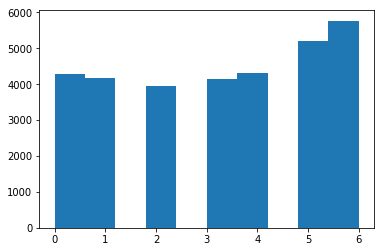

In [4]:
# This is an attempt to add day of the week of publishing as a feature.
# Since highest number of movies are published on thursday and friday, arrange weekdays so that x and y axes have a somewhat linear relationship.
def findDtOne(d):
    dtobj = datetime.strptime(d, '%Y-%m-%d')
    day = dtobj.weekday()
    day += 2
    if day == 7:
        day = 0
    elif day == 8:
        day = 1
    return day
findDt = np.vectorize(findDtOne)
wikidata = wikidata.dropna(axis=0, how='any')
wikidata['day'] = findDt(wikidata['publication_date'])

plt.hist(wikidata['day'])

In [5]:
#select neccessary columns and remove all rows containing any NaN values
rotten = rotten[['audience_average', 'audience_ratings', 'critic_average', 'critic_percent', 'rotten_tomatoes_id']];
rotten = rotten.dropna(axis=0, how='any');
rotten

,audience_average,audience_ratings,critic_average,critic_percent,rotten_tomatoes_id
0,3.9,33125227.0,7.1,79.0,m/pirates_of_the_caribbean_the_curse_of_the_bl...
1,4.1,2139.0,7.8,88.0,m/first_they_killed_my_father_a_daughter_of_ca...
2,3.6,11482.0,7.6,86.0,m/henry_portrait_of_a_serial_killer
3,3.6,187204.0,6.6,66.0,m/cloud_atlas_2012
4,3.9,26836.0,7.4,80.0,m/the_skin_i_live_in
5,3.7,1498.0,7.0,88.0,m/if_a_tree_falls_a_story_of_the_earth_liberat...
6,3.6,92824.0,6.6,73.0,m/1073595-sleepers
7,3.2,242347.0,4.9,35.0,m/abraham_lincoln_vampire_hunter
8,4.0,427.0,7.4,100.0,m/lost_soul_the_doomed_journey_of_richard_stan...
9,3.7,260776.0,7.4,85.0,m/1196003-princess_and_the_frog


In [6]:
#join all the data tables and remove NaN rows
wr = wikidata.set_index('rotten_tomatoes_id').join(rotten.set_index('rotten_tomatoes_id'))
wr = wr.dropna(axis=0, how='any');

# remove index columns and retain only the useful columns.
wr = wr.reset_index()
wr = wr.drop(['rotten_tomatoes_id'], axis=1)
wr

,cast_member,director,country_of_origin,original_language,genre,publication_date,day,audience_average,audience_ratings,critic_average,critic_percent
0,"[Q310343, Q161819, Q714729, Q258064, Q229477, ...",[Q56093],Q30,Q1860,[Q860626],1979-01-01,2,2.9,14648.0,6.4,68.0
1,"[Q312107, Q944638, Q348351, Q706165, Q286738, ...",[Q51559],Q30,Q1860,"[Q130232, Q3072039, Q21209409]",1957-04-10,4,4.2,104335.0,9.0,100.0
2,"[Q104049, Q229251, Q297816, Q462118, Q240233, ...",[Q52997],Q30,Q1860,[Q842256],1959-01-01,5,3.7,1062.0,7.6,83.0
3,"[Q104027, Q182057, Q209186, Q78505, Q472418, Q...",[Q262735],Q30,Q1860,"[Q471839, Q1615638, Q52162262]",1954-12-23,5,3.2,68837.0,7.7,89.0
4,"[Q692979, Q640929, Q1754108, Q67231, Q967062, ...",[Q2001],Q30,Q1860,"[Q471839, Q319221, Q2484376, Q130232, Q5216226...",1968-04-02,3,3.8,297648.0,9.2,92.0
5,"[Q200407, Q387072, Q359325, Q2826070, Q6757586...",[Q60100],Q258,Q1860,"[Q157394, Q319221, Q471839, Q188473]",2008-02-22,6,2.9,411268.0,3.2,8.0
6,"[Q34012, Q679987, Q719266, Q455010, Q37175, Q3...",[Q37175],Q30,Q1860,[Q130232],1997-01-01,4,3.6,13315.0,4.7,33.0
7,"[Q116983, Q242656, Q71463, Q5576559, Q230832, ...",[Q7374],Q145,Q1860,"[Q2297927, Q1200678, Q52162262]",1935-01-01,3,3.9,23739.0,8.9,96.0
8,"[Q212048, Q350678, Q445079, Q2074596, Q1375484...",[Q95119],Q30,Q1860,[Q172980],1957-01-01,3,3.7,9206.0,7.6,96.0
9,"[Q123476, Q39666, Q79152, Q1210511, Q2825262, ...",[Q768946],Q142,Q150,"[Q222639, Q319221]",2003-01-01,4,2.9,2323.0,5.0,14.0


# WHAT ARE WE PREDICTING? IS THE PREDICTION VARIABLE VALID?

We are trying to predict the audience average score and/or critic average score. However, we found some fatal problems with the way values are distributed in the categories.

## Fixing Audience Score Categories

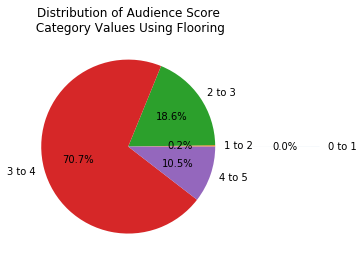

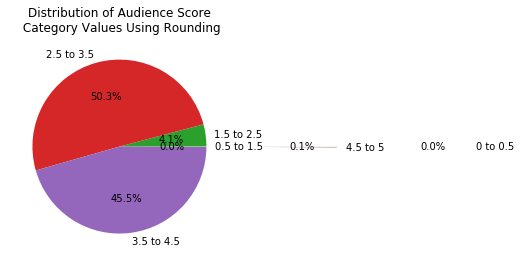

In [7]:
# the audience average feature is spread out normally, so 70% of ratings fall in between 3 and 4. 
# Remember that we were thinking of flooring (or rounding) the scores for classification, which would map every number between 3 and 4 to just 3.
# In case of flooring, the model can predict 3 every time and get an accuracy score of 70%. Rounding has the same type of problem.
# Let's visualize this problem. Create a pie chart to see the distribution of values for flooring.
aap = wr['audience_average']
aap_floor = np.floor(aap)

arraySizes = [
    aap_floor[aap_floor == 0.0].size,
    aap_floor[aap_floor == 1.0].size,
    aap_floor[aap_floor == 2.0].size,
    aap_floor[aap_floor == 3.0].size,
    aap_floor[aap_floor == 4.0].size,
#     aap_floor[aap_floor == 5.0].size  #took out 5 because no data points found
]

labels = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]
plt.pie(arraySizes, explode=(1.2, 0, 0, 0, 0), autopct='%1.1f%%', labels = labels)
plt.title("Distribution of Audience Score\n Category Values Using Flooring")
plt.show()

# Same problem occurs with rounding.
aap_round = np.round(aap)

arraySizes2 = [
    aap_round[aap_round == 0.0].size,
    aap_round[aap_round == 1.0].size,
    aap_round[aap_round == 2.0].size,
    aap_round[aap_round == 3.0].size,
    aap_round[aap_round == 4.0].size,
    aap_round[aap_round == 5.0].size
]

labels = ["0 to 0.5", "0.5 to 1.5", "1.5 to 2.5", "2.5 to 3.5", "3.5 to 4.5", "4.5 to 5"]
plt.pie(arraySizes2, explode=(3, 0, 0, 0, 0, 1.5), autopct='%1.1f%%', labels = labels)
plt.title("Distribution of Audience Score\n Category Values Using Rounding")
plt.show()

In [8]:
# Let's make the categories more even by grouping values with percentiles. In our case, we use pentiles.
# Find the pentiles (cutoff points)
aud_avg_np = np.array(wr['audience_average'])
_20 = np.percentile(aud_avg_np, 20)
_40 = np.percentile(aud_avg_np, 40)
_60 = np.percentile(aud_avg_np, 60)
_80 = np.percentile(aud_avg_np, 80)
print([_20,_40,_60,_80])

#categorize each average rating to a pentile (0 to 20th percentile, 20 to 40th... etc)
audAvgPercentiles = []
for a in wr['audience_average']:
    if a < _20:
        audAvgPercentiles.append(1)
    elif a < _40:
        audAvgPercentiles.append(2)
    elif a < _60:
        audAvgPercentiles.append(3)
    elif a < _80:
        audAvgPercentiles.append(4)
    else:
        audAvgPercentiles.append(5)

audAvgPercentilesDf = pd.DataFrame(audAvgPercentiles, columns=['audience_avg_pentile'])
wr = pd.concat([wr, audAvgPercentilesDf], ignore_index=False, axis=1)
show = pd.concat([wr['audience_average'], audAvgPercentilesDf], ignore_index=False, axis=1)
show

[3.0, 3.3, 3.5, 3.8]


,audience_average,audience_avg_pentile
0,2.9,1
1,4.2,5
2,3.7,4
3,3.2,2
4,3.8,5
5,2.9,1
6,3.6,4
7,3.9,5
8,3.7,4
9,2.9,1


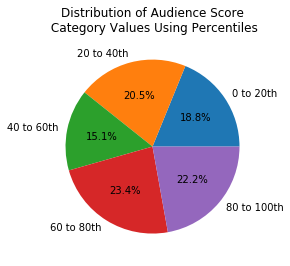

In [9]:
#now we see on a pie chart that the feature is more evenly spread out.
aap = wr['audience_avg_pentile']
arraySizes = [
    aap[aap == 1].count(),
    aap[aap == 2].count(),
    aap[aap == 3].count(),
    aap[aap == 4].count(),
    aap[aap == 5].count()
]

labels = ["0 to 20th", "20 to 40th", "40 to 60th", "60 to 80th", "80 to 100th"]
plt.pie(arraySizes, autopct='%1.1f%%', labels = labels)
plt.title("Distribution of Audience Score\n Category Values Using Percentiles")
plt.show()



## Fixing Critic Score Categories

[48, 1452, 5074, 6585, 1264]


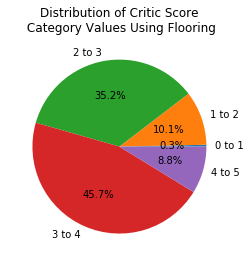

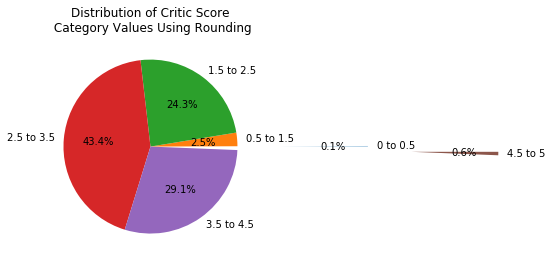

In [10]:
# the critic average feature is also spread out normally 
# Remember that we were thinking of flooring (or rounding) the scores for classification, which would map every number between 3 and 4 to just 3.
# In case of flooring, the model can predict 3 every time and get an accuracy score of 70%. Rounding has the same type of problem.
# Let's visualize this problem. Create a pie chart to see the distribution of values for flooring.
cap = wr['critic_average']
cap2 = np.divide(cap, 2)
cap_floor = np.floor(cap2)

arraySizes = [
    cap_floor[cap_floor == 0.0].size,
    cap_floor[cap_floor == 1.0].size,
    cap_floor[cap_floor == 2.0].size,
    cap_floor[cap_floor == 3.0].size,
    cap_floor[cap_floor == 4.0].size,
#     cap_floor[cap_floor == 5.0].size  #no data points found
]
print(arraySizes)
labels = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]
plt.pie(arraySizes, explode=(0, 0, 0, 0, 0), autopct='%1.1f%%', labels = labels)
plt.title("Distribution of Critic Score\n Category Values Using Flooring")
plt.show()

# Same problem occurs with rounding.
cap_round = np.round(cap2)

arraySizes2 = [
    cap_round[cap_round == 0.0].size,
    cap_round[cap_round == 1.0].size,
    cap_round[cap_round == 2.0].size,
    cap_round[cap_round == 3.0].size,
    cap_round[cap_round == 4.0].size,
    cap_round[cap_round == 5.0].size
]

labels = ["0 to 0.5", "0.5 to 1.5", "1.5 to 2.5", "2.5 to 3.5", "3.5 to 4.5", "4.5 to 5"]
plt.pie(arraySizes2, explode=(1.5, 0, 0, 0, 0, 3.0), autopct='%1.1f%%', labels = labels)
plt.title("Distribution of Critic Score\n Category Values Using Rounding")
plt.show()

In [11]:
# Let's make the categories more even by grouping values with percentiles. In our case, we use pentiles.
# Find the pentiles (cutoff points)
crit_avg_np = np.array(wr['critic_average'])
_20 = np.percentile(crit_avg_np, 20)
_40 = np.percentile(crit_avg_np, 40)
_60 = np.percentile(crit_avg_np, 60)
_80 = np.percentile(crit_avg_np, 80)
print([_20,_40,_60,_80])

#categorize each average rating to a pentile (0 to 20th percentile, 20 to 40th... etc)
critAvgPercentiles = []
for a in wr['critic_average']:
    if a < _20:
        critAvgPercentiles.append(1)
    elif a < _40:
        critAvgPercentiles.append(2)
    elif a < _60:
        critAvgPercentiles.append(3)
    elif a < _80:
        critAvgPercentiles.append(4)
    else:
        critAvgPercentiles.append(5)

critAvgPercentilesDf = pd.DataFrame(critAvgPercentiles, columns=['critic_avg_pentile'])
wr = pd.concat([wr, critAvgPercentilesDf], ignore_index=False, axis=1)
show = pd.concat([wr['critic_average'], critAvgPercentilesDf], ignore_index=False, axis=1)
show

[4.7, 5.7, 6.5, 7.300000000000001]


,critic_average,critic_avg_pentile
0,6.4,3
1,9.0,5
2,7.6,5
3,7.7,5
4,9.2,5
5,3.2,1
6,4.7,2
7,8.9,5
8,7.6,5
9,5.0,2


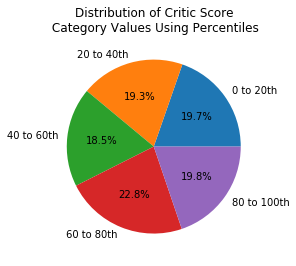

In [12]:
#now we see on a pie chart that the feature is more evenly spread out.
cap = wr['critic_avg_pentile']
arraySizes = [
    cap[cap == 1].count(),
    cap[cap == 2].count(),
    cap[cap == 3].count(),
    cap[cap == 4].count(),
    cap[cap == 5].count()
]

labels = ["0 to 20th", "20 to 40th", "40 to 60th", "60 to 80th", "80 to 100th"]
plt.pie(arraySizes, autopct='%1.1f%%', labels = labels)
plt.title("Distribution of Critic Score\n Category Values Using Percentiles")
plt.show()



# What to Do with Categorical Variables?

The general idea is to convert cast_member, director, and genres columns to meaningful variables before running them on machine learning algorithms.

Cast_member column will be converted to the following features:
count casts who appeared in n>=15 movies, ..in 15>n>=8 movies, ..in 8>n>=1 movies. This is analogous to counting how many popular movie stars are featured in a movie. The new features were designed this way because simply using dummy variables (i.e. binarizing) would result to too many sparsely populated features, which would result in overfitting of models.

Same idea applies for director column.

Genres will be converted to dummy variables (basically, add new column for each genre and the value for each column will be boolean. e.g. 'horror' column has 0 or 1 for each movie). Since adding too many features will result in overfitting, we should bag the lowest-occurence genres together into one feature)
(resource: https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512)

In [13]:
# These are functions that will be used later during bagging the features
# define count function. count each item in a column and record the count information in a dictionary.
def countEach(listdata, counts):
    for item in listdata:
        counts[item] = counts.get(item, 0) + 1

countCol = np.vectorize(countEach)        

# print the dict keys and values, sorted by its values.
def printSortedDict(dic):
    for w in sorted(dic, key=dic.get, reverse=True):
        print (w + ": " + str(dic[w]))

# plot the dict keys and values, sorted by its values.
def plotSortedDict(dic):
    y_pos = np.arange(len(dic))
    y = []
    for w in sorted(dic, key=dic.get, reverse=True):
        y.append(dic[w])
    plt.bar(y_pos, y, align='center', alpha=0.5)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.ylabel('Count')
    plt.figure(figsize=(20,10))
    plt.show()


## Bagging Cast Member Feature

In [14]:
# process the cast_member column
castCounts = {}
casts = np.array(wikidata['cast_member'])
countCol(casts, castCounts)
#let's get a feel for how many movies each cast has been in (within the list). 
#The plot takes a long time to run so I've attached the result.
printSortedDict(castCounts)
# plotSortedDict(castCounts) #this takes a long time to compute

Q180338: 142
Q106508: 113
Q40531: 112
Q172678: 108
Q123351: 107
Q103784: 100
Q36949: 98
Q312878: 94
Q185051: 92
Q16766: 88
Q2680: 88
Q203215: 87
Q314914: 86
Q171736: 85
Q191132: 85
Q104061: 83
Q2737: 83
Q133050: 83
Q1280760: 81
Q295257: 81
Q55469: 80
Q72911: 80
Q200405: 80
Q188772: 80
Q72869: 79
Q367129: 79
Q36970: 78
Q48337: 77
Q190523: 77
Q102711: 77
Q83484: 77
Q309589: 76
Q55419: 75
Q58444: 75
Q1867601: 74
Q244234: 73
Q150943: 73
Q42869: 72
Q71206: 71
Q209186: 71
Q106365: 71
Q16472: 71
Q498420: 71
Q213574: 71
Q203219: 70
Q201279: 70
Q219640: 69
Q173158: 69
Q314290: 69
Q313043: 69
Q65932: 68
Q223830: 68
Q37175: 68
Q207969: 68
Q19155: 68
Q188018: 68
Q172261: 67
Q104027: 67
Q106175: 67
Q165219: 67
Q4573: 67
Q104791: 67
Q106418: 67
Q117392: 66
Q40026: 66
Q36105: 65
Q95043: 65
Q34975: 65
Q230636: 65
Q102551: 65
Q181917: 65
Q102462: 65
Q80405: 65
Q9570: 65
Q202148: 65
Q43203: 64
Q215072: 64
Q170572: 64
Q182763: 64
Q1277973: 64
Q83338: 63
Q26806: 63
Q77035: 63
Q105221: 63
Q40475: 62
Q56016

Q236074: 17
Q3434592: 17
Q353758: 17
Q555828: 17
Q201617: 17
Q961495: 17
Q451567: 17
Q2832333: 17
Q1255329: 17
Q1044734: 17
Q3012414: 17
Q2590462: 17
Q3569553: 17
Q453774: 17
Q1334710: 17
Q325661: 17
Q370181: 17
Q234360: 17
Q1385393: 17
Q234890: 17
Q79005: 17
Q808435: 17
Q269901: 17
Q1388853: 17
Q94167: 17
Q3858821: 17
Q579505: 17
Q383930: 17
Q336689: 17
Q239849: 17
Q2697231: 17
Q164976: 17
Q920607: 17
Q944638: 17
Q233826: 17
Q1252512: 17
Q259536: 17
Q229187: 17
Q442728: 17
Q215026: 17
Q679110: 17
Q544618: 17
Q240217: 17
Q433601: 17
Q82660: 17
Q254166: 17
Q266229: 17
Q287793: 17
Q182292: 17
Q2159451: 17
Q253328: 17
Q239046: 17
Q18916: 17
Q459945: 17
Q377450: 17
Q709942: 17
Q336282: 17
Q860876: 17
Q611096: 17
Q232837: 17
Q351479: 17
Q379157: 17
Q259434: 17
Q228925: 17
Q242477: 17
Q3101495: 17
Q312719: 17
Q240869: 17
Q354664: 17
Q531869: 17
Q236738: 17
Q55366: 17
Q786003: 17
Q288114: 17
Q1052640: 17
Q657541: 17
Q489: 17
Q2734945: 17
Q615880: 17
Q238081: 17
Q634574: 17
Q290438: 17
Q437157

Q313306: 11
Q437027: 11
Q470027: 11
Q109366: 11
Q731628: 11
Q1395882: 11
Q200460: 11
Q78119: 11
Q432979: 11
Q5308817: 11
Q241268: 11
Q95178: 11
Q3453627: 11
Q189438: 11
Q736541: 11
Q3952829: 11
Q2832945: 11
Q95008: 11
Q616982: 11
Q275337: 11
Q3048083: 11
Q1269785: 11
Q16337574: 11
Q3385032: 11
Q862427: 11
Q3827125: 11
Q439962: 11
Q435925: 11
Q439800: 11
Q376176: 11
Q250539: 11
Q1054390: 11
Q553037: 11
Q262862: 11
Q533470: 11
Q978367: 11
Q531195: 11
Q265661: 11
Q215511: 11
Q470190: 11
Q441634: 11
Q4801965: 11
Q1198897: 11
Q3106819: 11
Q69092: 11
Q212224: 11
Q705523: 11
Q1345052: 11
Q72267: 11
Q1118823: 11
Q715606: 11
Q4241574: 11
Q2338805: 11
Q325767: 11
Q254828: 11
Q3157337: 11
Q330183: 11
Q1140135: 11
Q465152: 11
Q359665: 11
Q262170: 11
Q1457631: 11
Q257065: 11
Q371710: 11
Q454951: 11
Q304828: 11
Q1680201: 11
Q467729: 11
Q313001: 11
Q283504: 11
Q86293: 11
Q3194107: 11
Q4328437: 11
Q2980691: 11
Q1143938: 11
Q370450: 11
Q545073: 11
Q78924: 11
Q312524: 11
Q324572: 11
Q1260674: 11
Q315951

Q3316005: 7
Q302314: 7
Q18718708: 7
Q638129: 7
Q3471167: 7
Q118052: 7
Q3158966: 7
Q1358453: 7
Q3292505: 7
Q462590: 7
Q2641146: 7
Q3306307: 7
Q5218961: 7
Q742043: 7
Q264986: 7
Q1553389: 7
Q3719841: 7
Q927681: 7
Q785197: 7
Q2941870: 7
Q3194132: 7
Q3315530: 7
Q3351171: 7
Q71463: 7
Q3023155: 7
Q238197: 7
Q3547009: 7
Q2853651: 7
Q2865935: 7
Q2379706: 7
Q3169986: 7
Q759001: 7
Q513632: 7
Q1740088: 7
Q2272497: 7
Q4289700: 7
Q68134: 7
Q449265: 7
Q1044341: 7
Q1388109: 7
Q3124676: 7
Q450442: 7
Q75579: 7
Q1586724: 7
Q944245: 7
Q277356: 7
Q3264373: 7
Q3103625: 7
Q3386981: 7
Q25839: 7
Q2469299: 7
Q3367537: 7
Q3427154: 7
Q731602: 7
Q2405722: 7
Q3498689: 7
Q1527999: 7
Q445538: 7
Q449309: 7
Q3016398: 7
Q443327: 7
Q701585: 7
Q3170114: 7
Q3490942: 7
Q1338138: 7
Q135903: 7
Q22675384: 7
Q11230425: 7
Q10861544: 7
Q3833104: 7
Q3100050: 7
Q5132938: 7
Q3345518: 7
Q2439562: 7
Q933312: 7
Q328101: 7
Q253298: 7
Q485387: 7
Q1357886: 7
Q462654: 7
Q7940795: 7
Q12023932: 7
Q10857498: 7
Q1800016: 7
Q555650: 7
Q7940620:

Q440348: 5
Q2634077: 5
Q463287: 5
Q1648334: 5
Q1164620: 5
Q119564: 5
Q114152: 5
Q436978: 5
Q440: 5
Q3165067: 5
Q90221: 5
Q7938803: 5
Q11926027: 5
Q11773845: 5
Q1197220: 5
Q3379745: 5
Q3317234: 5
Q434244: 5
Q2271226: 5
Q189453: 5
Q125849: 5
Q536519: 5
Q326716: 5
Q461321: 5
Q1412648: 5
Q2535851: 5
Q1640475: 5
Q6873993: 5
Q12023235: 5
Q1320245: 5
Q786106: 5
Q3453472: 5
Q4647891: 5
Q3836849: 5
Q327732: 5
Q487198: 5
Q1040975: 5
Q3719608: 5
Q470252: 5
Q3619161: 5
Q2095952: 5
Q3518353: 5
Q3849095: 5
Q3929190: 5
Q3738074: 5
Q4699624: 5
Q432953: 5
Q3603296: 5
Q3972982: 5
Q65359: 5
Q3680253: 5
Q3176005: 5
Q460796: 5
Q142045: 5
Q2575446: 5
Q459623: 5
Q3761126: 5
Q1239330: 5
Q3749736: 5
Q3960762: 5
Q459348: 5
Q3018855: 5
Q508720: 5
Q638495: 5
Q3028382: 5
Q1896231: 5
Q466705: 5
Q1195788: 5
Q3301697: 5
Q3887022: 5
Q3629717: 5
Q7344031: 5
Q3737852: 5
Q3737626: 5
Q3376687: 5
Q1273515: 5
Q3617585: 5
Q3742891: 5
Q2341317: 5
Q3845634: 5
Q12410872: 5
Q620822: 5
Q2627090: 5
Q3956291: 5
Q313138: 5
Q40124: 5

Q698155: 4
Q471157: 4
Q485004: 4
Q1047230: 4
Q202663: 4
Q5479879: 4
Q1281533: 4
Q7114140: 4
Q448282: 4
Q19526: 4
Q5982633: 4
Q6968788: 4
Q3286692: 4
Q275266: 4
Q435878: 4
Q276468: 4
Q713738: 4
Q443766: 4
Q1806230: 4
Q105493: 4
Q1280675: 4
Q531443: 4
Q5337205: 4
Q4767285: 4
Q724812: 4
Q9033587: 4
Q4662339: 4
Q6455419: 4
Q6900353: 4
Q5548829: 4
Q236374: 4
Q40132: 4
Q6834504: 4
Q434776: 4
Q5261969: 4
Q38410137: 4
Q6451452: 4
Q258999: 4
Q261056: 4
Q19519424: 4
Q8345274: 4
Q458175: 4
Q2849503: 4
Q444699: 4
Q5791447: 4
Q3067366: 4
Q1861772: 4
Q3160561: 4
Q519098: 4
Q3175094: 4
Q3509625: 4
Q2449272: 4
Q452475: 4
Q377593: 4
Q271655: 4
Q456952: 4
Q3929913: 4
Q3536892: 4
Q454374: 4
Q490711: 4
Q536552: 4
Q443508: 4
Q3640043: 4
Q12403885: 4
Q2838955: 4
Q5685849: 4
Q5949287: 4
Q1147611: 4
Q1937199: 4
Q272022: 4
Q12755571: 4
Q437640: 4
Q7851264: 4
Q5335988: 4
Q5365444: 4
Q12739634: 4
Q2409726: 4
Q960141: 4
Q6347764: 4
Q7910998: 4
Q253167: 4
Q326984: 4
Q3666680: 4
Q18043858: 4
Q4980063: 4
Q4143127: 4

Q5934504: 3
Q723085: 3
Q4886665: 3
Q2383842: 3
Q3142726: 3
Q2254520: 3
Q5039778: 3
Q1791430: 3
Q5571781: 3
Q18238317: 3
Q16946447: 3
Q1189358: 3
Q446364: 3
Q2934814: 3
Q7341673: 3
Q461378: 3
Q1092306: 3
Q457760: 3
Q4569397: 3
Q4569905: 3
Q5397172: 3
Q5408666: 3
Q263256: 3
Q7285873: 3
Q6197213: 3
Q2470184: 3
Q6983286: 3
Q3548197: 3
Q459861: 3
Q259103: 3
Q20031439: 3
Q533692: 3
Q4947416: 3
Q4971140: 3
Q2882236: 3
Q15956720: 3
Q2347415: 3
Q10857452: 3
Q3503936: 3
Q7701884: 3
Q4083747: 3
Q8000017: 3
Q5219229: 3
Q4777014: 3
Q6134003: 3
Q5591498: 3
Q28070847: 3
Q5377630: 3
Q1290006: 3
Q706680: 3
Q18354542: 3
Q3498453: 3
Q5801804: 3
Q3459336: 3
Q724868: 3
Q869056: 3
Q546396: 3
Q4580829: 3
Q3356840: 3
Q7845435: 3
Q16830404: 3
Q3372751: 3
Q965701: 3
Q1078175: 3
Q2778362: 3
Q652295: 3
Q3292613: 3
Q6184585: 3
Q496868: 3
Q747723: 3
Q498097: 3
Q15069945: 3
Q5289542: 3
Q1820729: 3
Q467973: 3
Q4667424: 3
Q3536800: 3
Q13527911: 3
Q440305: 3
Q9583962: 3
Q565518: 3
Q11169657: 3
Q1476759: 3
Q84524: 3
Q10

Q378923: 3
Q3519495: 3
Q5515696: 3
Q547293: 3
Q3176720: 3
Q3660157: 3
Q1990529: 3
Q5524761: 3
Q722059: 3
Q291693: 3
Q384522: 3
Q107404: 3
Q7806890: 3
Q11898026: 3
Q11901044: 3
Q553888: 3
Q3570192: 3
Q286512: 3
Q2308892: 3
Q365144: 3
Q931043: 3
Q3342659: 3
Q2745262: 3
Q3362157: 3
Q12332902: 3
Q3372515: 3
Q3424845: 3
Q3470768: 3
Q287346: 3
Q3426829: 3
Q1444043: 3
Q3176288: 3
Q2573882: 3
Q4945976: 3
Q2498137: 3
Q3427943: 3
Q110425: 3
Q9384814: 3
Q11858349: 3
Q16989612: 3
Q929509: 3
Q3290621: 3
Q3336552: 3
Q171557: 3
Q1563376: 3
Q229349: 3
Q3787526: 3
Q3082061: 3
Q3010139: 3
Q331748: 3
Q12321841: 3
Q12343120: 3
Q3369289: 3
Q199801: 3
Q11982784: 3
Q5628835: 3
Q4759355: 3
Q23833907: 3
Q13860314: 3
Q4108147: 3
Q546940: 3
Q2287667: 3
Q2975132: 3
Q3340618: 3
Q6062669: 3
Q1894164: 3
Q2441446: 3
Q3161926: 3
Q15070000: 3
Q260298: 3
Q492138: 3
Q17714: 3
Q328254: 3
Q2272478: 3
Q178037: 3
Q233817: 3
Q2262213: 3
Q111267: 3
Q4757751: 3
Q448899: 3
Q3276701: 3
Q241418: 3
Q446914: 3
Q2883939: 3
Q1175381: 

Q2878626: 2
Q918655: 2
Q5292195: 2
Q1250868: 2
Q464802: 2
Q402779: 2
Q1638889: 2
Q6428891: 2
Q463068: 2
Q5571397: 2
Q3109650: 2
Q456460: 2
Q3968236: 2
Q892001: 2
Q7040015: 2
Q7926714: 2
Q6762026: 2
Q2881057: 2
Q5537698: 2
Q6035690: 2
Q254576: 2
Q5806494: 2
Q5392959: 2
Q4352839: 2
Q18221436: 2
Q6120002: 2
Q28070848: 2
Q6055778: 2
Q12055526: 2
Q12775298: 2
Q12022899: 2
Q1449324: 2
Q6774435: 2
Q12035606: 2
Q12024203: 2
Q5879619: 2
Q3110797: 2
Q813553: 2
Q8961455: 2
Q3548945: 2
Q6128570: 2
Q981782: 2
Q3307106: 2
Q468707: 2
Q6080989: 2
Q16583539: 2
Q2327008: 2
Q6844643: 2
Q952077: 2
Q8346795: 2
Q4811424: 2
Q7322902: 2
Q4147764: 2
Q2827359: 2
Q3511530: 2
Q6082171: 2
Q3111811: 2
Q1936124: 2
Q19522815: 2
Q6773370: 2
Q7608558: 2
Q6963590: 2
Q3534651: 2
Q594270: 2
Q781262: 2
Q542574: 2
Q5120573: 2
Q17495881: 2
Q7237601: 2
Q7361477: 2
Q11188692: 2
Q1562297: 2
Q2757381: 2
Q6546971: 2
Q5474627: 2
Q356794: 2
Q1382876: 2
Q5807480: 2
Q5885116: 2
Q5626688: 2
Q966618: 2
Q6938628: 2
Q2080415: 2
Q4753770:

Q4911011: 2
Q1176607: 2
Q1436870: 2
Q314342: 2
Q247251: 2
Q242949: 2
Q6381184: 2
Q281962: 2
Q431293: 2
Q4704882: 2
Q694081: 2
Q5214844: 2
Q766333: 2
Q3470421: 2
Q979276: 2
Q1114149: 2
Q11516815: 2
Q3288504: 2
Q707132: 2
Q2851673: 2
Q336555: 2
Q584668: 2
Q3603064: 2
Q972451: 2
Q463674: 2
Q2859876: 2
Q5056128: 2
Q25529: 2
Q601712: 2
Q529599: 2
Q3561514: 2
Q2679899: 2
Q1330092: 2
Q236613: 2
Q2092940: 2
Q287122: 2
Q21070316: 2
Q5727702: 2
Q3702786: 2
Q1682625: 2
Q87927: 2
Q1576075: 2
Q86437: 2
Q2938806: 2
Q3425829: 2
Q5129391: 2
Q1967262: 2
Q11125969: 2
Q535412: 2
Q106464: 2
Q7635124: 2
Q42418312: 2
Q1900238: 2
Q3219408: 2
Q11837528: 2
Q4018958: 2
Q1185321: 2
Q483407: 2
Q6281408: 2
Q741465: 2
Q18638535: 2
Q1770430: 2
Q6371057: 2
Q357735: 2
Q1856563: 2
Q1900383: 2
Q5108143: 2
Q55718: 2
Q9312285: 2
Q11728671: 2
Q11749223: 2
Q11685072: 2
Q11720795: 2
Q9202088: 2
Q11725267: 2
Q162035: 2
Q1689472: 2
Q432710: 2
Q1422201: 2
Q357856: 2
Q32754: 2
Q927052: 2
Q1810579: 2
Q16613501: 2
Q4116946: 2
Q160

Q15973425: 2
Q3383429: 2
Q423008: 2
Q240187: 2
Q1626837: 2
Q1887003: 2
Q203653: 2
Q4105674: 2
Q330889: 2
Q4901177: 2
Q1684854: 2
Q22280962: 2
Q8070192: 2
Q444393: 2
Q16083699: 2
Q185002: 2
Q1905257: 2
Q1148858: 2
Q12320385: 2
Q15944154: 2
Q3427596: 2
Q2535137: 2
Q5112848: 2
Q555460: 2
Q220461: 2
Q42656: 2
Q3675691: 2
Q78640: 2
Q893603: 2
Q1555111: 2
Q598372: 2
Q3265811: 2
Q21063105: 2
Q55444: 2
Q5807863: 2
Q1239160: 2
Q540659: 2
Q120448: 2
Q3524247: 2
Q2426482: 2
Q47122: 2
Q2980615: 2
Q903302: 2
Q1900431: 2
Q580335: 2
Q1097791: 2
Q3524815: 2
Q4279425: 2
Q1513677: 2
Q1281757: 2
Q1163254: 2
Q110569: 2
Q3350974: 2
Q2837131: 2
Q3124601: 2
Q1284021: 2
Q1132832: 2
Q2209514: 2
Q436540: 2
Q2524092: 2
Q94187: 2
Q486959: 2
Q12601441: 2
Q12601402: 2
Q486180: 2
Q3124163: 2
Q11715212: 2
Q11772356: 2
Q1044249: 2
Q104702: 2
Q68448: 2
Q1572163: 2
Q513402: 2
Q18395801: 2
Q231182: 2
Q5542519: 2
Q2768812: 2
Q2781686: 2
Q15451674: 2
Q1402293: 2
Q2628278: 2
Q4363984: 2
Q4307870: 2
Q1781919: 2
Q436693: 2
Q1

Q3149149: 2
Q540784: 2
Q3490982: 2
Q272296: 2
Q7383107: 2
Q362687: 2
Q4346479: 2
Q4346032: 2
Q235451: 2
Q536992: 2
Q235323: 2
Q440286: 2
Q4025870: 2
Q3155649: 2
Q953560: 2
Q3177495: 2
Q776240: 2
Q13104377: 2
Q2225483: 2
Q16440266: 2
Q242595: 2
Q17107093: 2
Q540574: 2
Q3892891: 2
Q12876861: 2
Q230424: 2
Q348410: 2
Q3182931: 2
Q3014061: 2
Q1542058: 2
Q3301491: 2
Q531540: 2
Q2379973: 2
Q16728739: 2
Q1718698: 2
Q4971498: 2
Q5781821: 2
Q522724: 2
Q1137777: 2
Q3293092: 2
Q3138654: 2
Q465881: 2
Q3383016: 2
Q16170698: 2
Q5585258: 2
Q1390945: 2
Q91795: 2
Q2850650: 2
Q100220: 2
Q4011271: 2
Q3180942: 2
Q2942047: 2
Q15069875: 2
Q7177164: 2
Q1582741: 2
Q11779750: 2
Q3015878: 2
Q40117: 2
Q503938: 2
Q951523: 2
Q7113315: 2
Q3086462: 2
Q536603: 2
Q6147167: 2
Q333452: 2
Q1421824: 2
Q3088199: 2
Q241081: 2
Q5372082: 2
Q6055158: 2
Q1059620: 2
Q6380740: 2
Q3158249: 2
Q2861155: 2
Q1986025: 2
Q12022619: 2
Q5120590: 2
Q737012: 2
Q330404: 2
Q1827805: 2
Q1896912: 2
Q1330248: 2
Q456348: 2
Q3442224: 2
Q530602: 2
Q

Q42383984: 1
Q42383987: 1
Q42383989: 1
Q42383992: 1
Q42383993: 1
Q42383996: 1
Q42383997: 1
Q21004156: 1
Q42384001: 1
Q42384005: 1
Q42384006: 1
Q42384008: 1
Q42384009: 1
Q26267744: 1
Q42384014: 1
Q42384015: 1
Q42384018: 1
Q42384020: 1
Q42384023: 1
Q42384024: 1
Q42384026: 1
Q42384027: 1
Q5399735: 1
Q12056530: 1
Q1137084: 1
Q2217166: 1
Q3958190: 1
Q1378202: 1
Q4973757: 1
Q373862: 1
Q4707671: 1
Q3086883: 1
Q29809869: 1
Q3852015: 1
Q5968121: 1
Q1546254: 1
Q9025436: 1
Q625552: 1
Q5517163: 1
Q5273581: 1
Q268017: 1
Q6217351: 1
Q6688957: 1
Q263681: 1
Q503851: 1
Q692808: 1
Q19401871: 1
Q4679793: 1
Q6097028: 1
Q6093425: 1
Q913693: 1
Q19301285: 1
Q5873775: 1
Q6004772: 1
Q600240: 1
Q324599: 1
Q2098609: 1
Q5618679: 1
Q6152857: 1
Q5562914: 1
Q7176691: 1
Q2342969: 1
Q6373686: 1
Q15410604: 1
Q6187648: 1
Q5739187: 1
Q6939100: 1
Q5346837: 1
Q11530062: 1
Q732416: 1
Q6101323: 1
Q16210350: 1
Q984426: 1
Q1634802: 1
Q6004029: 1
Q20013824: 1
Q1692165: 1
Q6069446: 1
Q6056960: 1
Q5666873: 1
Q6161040: 1
Q9009468:

Q9116361: 1
Q6143479: 1
Q9076318: 1
Q9348665: 1
Q6761308: 1
Q976243: 1
Q1371881: 1
Q55462: 1
Q934488: 1
Q195333: 1
Q959413: 1
Q369167: 1
Q4981604: 1
Q3894187: 1
Q241435: 1
Q3369551: 1
Q3964121: 1
Q3580169: 1
Q954370: 1
Q3349242: 1
Q3315752: 1
Q97921: 1
Q1415641: 1
Q15616069: 1
Q92658: 1
Q271772: 1
Q4738779: 1
Q5233518: 1
Q6307404: 1
Q17285091: 1
Q3737933: 1
Q5415543: 1
Q276883: 1
Q5521831: 1
Q2628835: 1
Q2386677: 1
Q3266376: 1
Q6429135: 1
Q16216655: 1
Q3275921: 1
Q11864578: 1
Q4732831: 1
Q5760981: 1
Q5106962: 1
Q6236286: 1
Q4725868: 1
Q1324613: 1
Q2839470: 1
Q4115616: 1
Q3961885: 1
Q2036549: 1
Q3311677: 1
Q3645107: 1
Q921687: 1
Q4742440: 1
Q16607908: 1
Q23879990: 1
Q832624: 1
Q13099499: 1
Q434907: 1
Q230916: 1
Q2856775: 1
Q3436170: 1
Q15104767: 1
Q16233245: 1
Q6255371: 1
Q2631649: 1
Q20090160: 1
Q16028331: 1
Q1142399: 1
Q945665: 1
Q1538416: 1
Q3293001: 1
Q729701: 1
Q3623758: 1
Q3856741: 1
Q471315: 1
Q53050: 1
Q4002923: 1
Q11826248: 1
Q3392082: 1
Q12025554: 1
Q27970212: 1
Q11218930: 1
Q

Q2903686: 1
Q4923033: 1
Q2926679: 1
Q299636: 1
Q79025: 1
Q15117828: 1
Q6548143: 1
Q737491: 1
Q173968: 1
Q3718878: 1
Q3016485: 1
Q3035063: 1
Q174305: 1
Q3168815: 1
Q975032: 1
Q58028: 1
Q1644728: 1
Q1346678: 1
Q313489: 1
Q638023: 1
Q2374504: 1
Q375858: 1
Q520940: 1
Q195129: 1
Q3179383: 1
Q369146: 1
Q4767223: 1
Q1799026: 1
Q5922059: 1
Q2756324: 1
Q4538191: 1
Q161852: 1
Q3852672: 1
Q12316346: 1
Q18211660: 1
Q1331362: 1
Q6834610: 1
Q5161959: 1
Q3308533: 1
Q373758: 1
Q3136619: 1
Q8018581: 1
Q7149216: 1
Q1384343: 1
Q361175: 1
Q525658: 1
Q745528: 1
Q741159: 1
Q8323287: 1
Q3106386: 1
Q1879921: 1
Q3938937: 1
Q325334: 1
Q270770: 1
Q1959635: 1
Q332937: 1
Q1953405: 1
Q11287354: 1
Q336272: 1
Q441742: 1
Q1571747: 1
Q128704: 1
Q1212381: 1
Q912752: 1
Q20728907: 1
Q23042982: 1
Q3256857: 1
Q6531791: 1
Q3120105: 1
Q15638494: 1
Q433576: 1
Q8045101: 1
Q6781940: 1
Q6299629: 1
Q4681882: 1
Q12308738: 1
Q12333702: 1
Q12339404: 1
Q1729465: 1
Q18421583: 1
Q7379818: 1
Q65550: 1
Q8322908: 1
Q457123: 1
Q993255: 1
Q1

Q2277553: 1
Q5231248: 1
Q5451095: 1
Q71388: 1
Q16223280: 1
Q7291527: 1
Q5057154: 1
Q4679158: 1
Q1044424: 1
Q3106692: 1
Q2745791: 1
Q256498: 1
Q5489486: 1
Q9297466: 1
Q8422697: 1
Q1194523: 1
Q1699698: 1
Q360002: 1
Q4800291: 1
Q3470078: 1
Q16163857: 1
Q178517: 1
Q190251: 1
Q192936: 1
Q5648945: 1
Q1651225: 1
Q5044320: 1
Q12340226: 1
Q38052468: 1
Q38052471: 1
Q12320459: 1
Q12326838: 1
Q37490631: 1
Q27834521: 1
Q20880650: 1
Q17417475: 1
Q26704332: 1
Q26926382: 1
Q26232134: 1
Q26926633: 1
Q27452406: 1
Q27064031: 1
Q22680869: 1
Q22114971: 1
Q130088: 1
Q12989491: 1
Q28147332: 1
Q22961724: 1
Q7539451: 1
Q20744972: 1
Q23774010: 1
Q30230711: 1
Q30230933: 1
Q18162361: 1
Q17285089: 1
Q5671500: 1
Q32732: 1
Q8071389: 1
Q1328545: 1
Q1586523: 1
Q22813458: 1
Q8054364: 1
Q1183831: 1
Q3023011: 1
Q29511133: 1
Q29513432: 1
Q29514181: 1
Q29514206: 1
Q29514363: 1
Q29514450: 1
Q29514454: 1
Q29514495: 1
Q29514503: 1
Q29514507: 1
Q29514595: 1
Q29514607: 1
Q29514941: 1
Q1195767: 1
Q1207368: 1
Q2173951: 1
Q1825239

Q33102218: 1
Q3656276: 1
Q6064958: 1
Q6056556: 1
Q6063329: 1
Q6086369: 1
Q6093603: 1
Q5238384: 1
Q2556156: 1
Q96244: 1
Q705708: 1
Q230733: 1
Q4768523: 1
Q4819123: 1
Q220458: 1
Q5233776: 1
Q3273781: 1
Q5771734: 1
Q4750480: 1
Q5253680: 1
Q314415: 1
Q290598: 1
Q3537444: 1
Q888671: 1
Q6163818: 1
Q6395780: 1
Q466580: 1
Q259094: 1
Q643399: 1
Q10317625: 1
Q10281007: 1
Q5219606: 1
Q7012813: 1
Q16941021: 1
Q10346822: 1
Q2345311: 1
Q1230431: 1
Q18589014: 1
Q7324155: 1
Q5325593: 1
Q982674: 1
Q312514: 1
Q3309911: 1
Q10347478: 1
Q9696979: 1
Q3326062: 1
Q2571507: 1
Q848556: 1
Q8063749: 1
Q1791562: 1
Q1336737: 1
Q6943157: 1
Q5042254: 1
Q509200: 1
Q2476992: 1
Q692841: 1
Q4961071: 1
Q22137355: 1
Q4983800: 1
Q22137360: 1
Q22137362: 1
Q22137364: 1
Q7145398: 1
Q5543536: 1
Q5745325: 1
Q3357415: 1
Q4990381: 1
Q6063214: 1
Q20261418: 1
Q13014829: 1
Q13012765: 1
Q13014657: 1
Q13016091: 1
Q16140160: 1
Q16438928: 1
Q13014724: 1
Q16434093: 1
Q709091: 1
Q8044373: 1
Q483668: 1
Q6907481: 1
Q2407677: 1
Q901575: 1
Q35

Q16856365: 1
Q35429: 1
Q8062656: 1
Q5250644: 1
Q3521637: 1
Q18132205: 1
Q4954378: 1
Q5686854: 1
Q6372511: 1
Q4965111: 1
Q6308221: 1
Q4730672: 1
Q5214085: 1
Q331791: 1
Q6709369: 1
Q1181586: 1
Q16149867: 1
Q7331732: 1
Q15825547: 1
Q18763973: 1
Q19954120: 1
Q16887692: 1
Q215708: 1
Q2371376: 1
Q22032529: 1
Q16240370: 1
Q22101574: 1
Q1041535: 1
Q1691423: 1
Q1356064: 1
Q7181642: 1
Q15732123: 1
Q374286: 1
Q462852: 1
Q80758: 1
Q16173210: 1
Q6290103: 1
Q11903371: 1
Q5511410: 1
Q44068: 1
Q7280194: 1
Q17061056: 1
Q23716150: 1
Q18917792: 1
Q23718882: 1
Q23718953: 1
Q1150569: 1
Q17388195: 1
Q436609: 1
Q5819539: 1
Q6122427: 1
Q5129215: 1
Q5403272: 1
Q8008631: 1
Q13038335: 1
Q18202739: 1
Q15944829: 1
Q661304: 1
Q1141482: 1
Q3734208: 1
Q3544514: 1
Q11665543: 1
Q11439842: 1
Q11532937: 1
Q9357411: 1
Q9075588: 1
Q11383707: 1
Q17425674: 1
Q19290273: 1
Q15694218: 1
Q4886311: 1
Q3941460: 1
Q26758644: 1
Q26758855: 1
Q26758872: 1
Q26758876: 1
Q26758883: 1
Q26758889: 1
Q26758892: 1
Q26758895: 1
Q26759588: 1
Q1

Q7384333: 1
Q332641: 1
Q2659453: 1
Q2956254: 1
Q3856925: 1
Q16542306: 1
Q1661268: 1
Q4799955: 1
Q1186047: 1
Q3179116: 1
Q3490450: 1
Q13424291: 1
Q21187842: 1
Q21187913: 1
Q5636749: 1
Q46993287: 1
Q4731180: 1
Q21188203: 1
Q539237: 1
Q21188321: 1
Q21188382: 1
Q21188475: 1
Q21188482: 1
Q7679556: 1
Q7398229: 1
Q6935622: 1
Q21188825: 1
Q3180083: 1
Q3179387: 1
Q3194124: 1
Q2899666: 1
Q1945836: 1
Q14930676: 1
Q8263605: 1
Q6163263: 1
Q6003675: 1
Q5698372: 1
Q6068297: 1
Q28065422: 1
Q3157723: 1
Q939313: 1
Q16195574: 1
Q839382: 1
Q3157688: 1
Q3195617: 1
Q5416245: 1
Q12875913: 1
Q2840857: 1
Q3058712: 1
Q3960661: 1
Q3701781: 1
Q442667: 1
Q7453138: 1
Q658394: 1
Q3461304: 1
Q622636: 1
Q441484: 1
Q3515222: 1
Q555311: 1
Q3369758: 1
Q3515170: 1
Q3560742: 1
Q945181: 1
Q3125444: 1
Q2824182: 1
Q2850755: 1
Q3052895: 1
Q4215746: 1
Q21475495: 1
Q20684836: 1
Q7692943: 1
Q15998597: 1
Q7540613: 1
Q3721427: 1
Q2857166: 1
Q459349: 1
Q1310139: 1
Q1348219: 1
Q5479859: 1
Q2848170: 1
Q2975509: 1
Q5444525: 1
Q1553804:

Q5622337: 1
Q3171527: 1
Q3290137: 1
Q3507368: 1
Q3576202: 1
Q6835302: 1
Q777790: 1
Q3720735: 1
Q17098501: 1
Q12301076: 1
Q13114438: 1
Q4130557: 1
Q5384743: 1
Q38053884: 1
Q12301029: 1
Q6686295: 1
Q2071087: 1
Q3856870: 1
Q559058: 1
Q3804816: 1
Q7327853: 1
Q7324644: 1
Q6812748: 1
Q1710007: 1
Q16193207: 1
Q4784027: 1
Q6385792: 1
Q1209252: 1
Q1173376: 1
Q3849561: 1
Q439920: 1
Q709499: 1
Q225852: 1
Q455605: 1
Q3435065: 1
Q17109874: 1
Q1871489: 1
Q5805180: 1
Q597917: 1
Q937232: 1
Q160163: 1
Q325679: 1
Q1681799: 1
Q4582058: 1
Q4120191: 1
Q4754888: 1
Q1773010: 1
Q27574631: 1
Q3354503: 1
Q3637944: 1
Q12057805: 1
Q12035296: 1
Q1733228: 1
Q1518680: 1
Q15430133: 1
Q6207150: 1
Q2622253: 1
Q4768209: 1
Q268099: 1
Q3858812: 1
Q1022003: 1
Q678217: 1
Q863008: 1
Q11855836: 1
Q4796806: 1
Q3992502: 1
Q3134025: 1
Q6536858: 1
Q1337569: 1
Q3287825: 1
Q16330981: 1
Q12875367: 1
Q12884701: 1
Q3116715: 1
Q515370: 1
Q3121404: 1
Q3560760: 1
Q5233732: 1
Q1536913: 1
Q436221: 1
Q44628: 1
Q1902494: 1
Q317374: 1
Q684569

Q1481587: 1
Q19258877: 1
Q10268486: 1
Q10327834: 1
Q13612488: 1
Q28100189: 1
Q6516259: 1
Q5230578: 1
Q4864354: 1
Q4285658: 1
Q3183178: 1
Q12814519: 1
Q7153247: 1
Q1127601: 1
Q1160284: 1
Q2941203: 1
Q18385091: 1
Q3082654: 1
Q3241922: 1
Q3559588: 1
Q7515159: 1
Q451009: 1
Q3085407: 1
Q3159998: 1
Q1108323: 1
Q3430489: 1
Q1613544: 1
Q3938551: 1
Q3345924: 1
Q3369616: 1
Q67231: 1
Q982722: 1
Q47087: 1
Q5218578: 1
Q7704327: 1
Q4974291: 1
Q21213208: 1
Q21213224: 1
Q21213245: 1
Q21213264: 1
Q21213307: 1
Q21213320: 1
Q5585899: 1
Q21213333: 1
Q516421: 1
Q16195381: 1
Q10314018: 1
Q7436695: 1
Q6811130: 1
Q5213433: 1
Q1588099: 1
Q1663641: 1
Q820883: 1
Q6912318: 1
Q5614101: 1
Q4727565: 1
Q19787940: 1
Q16193667: 1
Q3694931: 1
Q7395359: 1
Q1441807: 1
Q20819230: 1
Q12626679: 1
Q16106026: 1
Q6306035: 1
Q7688127: 1
Q6572984: 1
Q3548332: 1
Q7364230: 1
Q2655883: 1
Q2940554: 1
Q3058980: 1
Q4353707: 1
Q3443417: 1
Q6172370: 1
Q1753420: 1
Q2319135: 1
Q18223622: 1
Q1531129: 1
Q5946590: 1
Q5434809: 1
Q6560413: 1
Q5

Q4714441: 1
Q5491801: 1
Q6110741: 1
Q27865873: 1
Q2702472: 1
Q19946099: 1
Q1190160: 1
Q5045473: 1
Q16233514: 1
Q17279326: 1
Q3543742: 1
Q17488223: 1
Q322842: 1
Q4910422: 1
Q260056: 1
Q19560393: 1
Q19560090: 1
Q3161307: 1
Q6385651: 1
Q2175951: 1
Q4977202: 1
Q181484: 1
Q12859354: 1
Q6192987: 1
Q504706: 1
Q6537943: 1
Q16233594: 1
Q7149519: 1
Q22260535: 1
Q17174794: 1
Q16223951: 1
Q15916653: 1
Q16238750: 1
Q19605379: 1
Q4733460: 1
Q567437: 1
Q18946847: 1
Q4760014: 1
Q552376: 1
Q7938164: 1
Q7408695: 1
Q6828683: 1
Q42411425: 1
Q42411361: 1
Q42411362: 1
Q22670528: 1
Q42411364: 1
Q42411365: 1
Q42411366: 1
Q42411367: 1
Q42411368: 1
Q42411369: 1
Q42411370: 1
Q42411372: 1
Q42411373: 1
Q42411374: 1
Q42411376: 1
Q42411377: 1
Q42411379: 1
Q42411380: 1
Q42411381: 1
Q42411382: 1
Q42411383: 1
Q42411385: 1
Q42411386: 1
Q1126765: 1
Q18746304: 1
Q1665405: 1
Q16887870: 1
Q3524924: 1
Q5555432: 1
Q19677216: 1
Q458337: 1
Q613471: 1
Q316997: 1
Q21031714: 1
Q5070338: 1
Q2084794: 1
Q10623856: 1
Q3330458: 1
Q1690

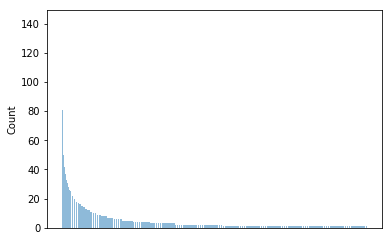

In [15]:
#iterate through all the casts of all movies and create a 2D np array which bags them into 3 groups
firstRow = np.zeros((1,3))
for i in range(wr['cast_member'].size):
    newRow = np.zeros((1,3))
    for c in wr['cast_member'][i]:
        if castCounts[c] >= 15:
            newRow[0][0] += 1
        elif castCounts[c] >= 8:
            newRow[0][1] += 1
        elif castCounts[c] >= 1:
            newRow[0][2] += 1
    firstRow = np.concatenate((firstRow, newRow), axis=0)

baggedCasts = np.delete(firstRow, (0), axis=0)
baggedCasts

array([[7., 6., 4.],
       [9., 3., 2.],
       [5., 2., 2.],
       ...,
       [4., 2., 2.],
       [6., 2., 3.],
       [8., 5., 1.]])

## Bagging Director Feature

In [16]:
# for each director in a movie, 
dirCounts = {}
directors = np.array(wikidata['director'])
countCol(directors, dirCounts)

#let's get a feel for how many movies each director has directed (within the list). 
#The plot takes a long time to run so I've attached the result.
printSortedDict(dirCounts)
# plotSortedDict(dirCounts) #this takes a long time to compute

Q51491: 63
Q555092: 61
Q1804597: 56
Q7374: 55
Q216748: 54
Q55375: 50
Q56014: 50
Q25089: 48
Q72756: 45
Q51114: 44
Q706678: 44
Q318292: 43
Q51575: 43
Q290962: 42
Q1479869: 42
Q7546: 41
Q707336: 40
Q103788: 40
Q95111: 39
Q51559: 38
Q41148: 38
Q2064707: 37
Q44131: 37
Q43203: 37
Q457250: 36
Q1359422: 36
Q456979: 35
Q951821: 35
Q547078: 35
Q145422: 35
Q55163: 35
Q51581: 35
Q55413: 33
Q470104: 33
Q1261335: 33
Q269731: 33
Q56093: 33
Q725060: 32
Q1384550: 32
Q59821: 32
Q61859: 32
Q52997: 32
Q8877: 32
Q262735: 31
Q53001: 31
Q1386207: 31
Q51495: 31
Q453683: 30
Q713165: 30
Q457269: 30
Q53026: 30
Q72229: 30
Q185421: 30
Q745414: 29
Q106685: 29
Q262820: 29
Q189526: 29
Q19504: 29
Q8006: 29
Q55411: 29
Q44426: 28
Q95133: 28
Q295093: 28
Q51566: 28
Q455043: 27
Q435029: 27
Q56005: 27
Q103646: 27
Q361670: 26
Q314882: 26
Q56094: 26
Q353758: 26
Q295855: 26
Q50764: 26
Q51498: 26
Q55234: 26
Q983092: 26
Q934087: 26
Q1361631: 26
Q103917: 26
Q53004: 26
Q51535: 26
Q345217: 26
Q55258: 26
Q51552: 26
Q51547: 26
Q43396

Q4216283: 2
Q1779549: 2
Q3270014: 2
Q563542: 2
Q1022522: 2
Q3193180: 2
Q139735: 2
Q1398256: 2
Q3372362: 2
Q2089072: 2
Q4679649: 2
Q3092707: 2
Q3241813: 2
Q2829735: 2
Q11645981: 2
Q19664519: 2
Q332670: 2
Q3089624: 2
Q8071326: 2
Q718780: 2
Q3380924: 2
Q3901505: 2
Q3159463: 2
Q329549: 2
Q275597: 2
Q2930444: 2
Q200525: 2
Q2928623: 2
Q9124527: 2
Q26263374: 2
Q3134613: 2
Q89056: 2
Q3084424: 2
Q2636752: 2
Q3350789: 2
Q91969: 2
Q238616: 2
Q595112: 2
Q2115400: 2
Q3505238: 2
Q151414: 2
Q336795: 2
Q1005321: 2
Q357762: 2
Q7150035: 2
Q1059776: 2
Q287828: 2
Q2863266: 2
Q6243454: 2
Q16193364: 2
Q2055340: 2
Q3430994: 2
Q55426: 2
Q2056096: 2
Q1157396: 2
Q3437083: 2
Q1107744: 2
Q4830910: 2
Q19818443: 2
Q4679159: 2
Q6446589: 2
Q3624308: 2
Q1232980: 2
Q3342561: 2
Q2159547: 2
Q16908467: 2
Q7347704: 2
Q3929980: 2
Q2034576: 2
Q7487091: 2
Q5238454: 2
Q44707: 2
Q2436141: 2
Q673304: 2
Q360140: 2
Q11360816: 2
Q5534071: 2
Q498430: 2
Q13091171: 2
Q6143165: 2
Q443083: 2
Q7350413: 2
Q2610508: 2
Q763507: 2
Q16885837:

Q20687780: 1
Q23762172: 1
Q20071786: 1
Q21066713: 1
Q6791043: 1
Q1098003: 1
Q24572216: 1
Q28497856: 1
Q697383: 1
Q24061147: 1
Q22277301: 1
Q13560473: 1
Q27662887: 1
Q5798422: 1
Q233347: 1
Q1582632: 1
Q24640014: 1
Q24640016: 1
Q27832751: 1
Q24590945: 1
Q3371986: 1
Q24681564: 1
Q1421616: 1
Q6721191: 1
Q27685115: 1
Q4943414: 1
Q30727048: 1
Q3401333: 1
Q16730489: 1
Q23819589: 1
Q336905: 1
Q6767947: 1
Q48699392: 1
Q2657694: 1
Q6897291: 1
Q4764239: 1
Q35438529: 1
Q12321689: 1
Q2408960: 1
Q3501925: 1
Q5544337: 1
Q1605553: 1
Q11585892: 1
Q22101425: 1
Q8200132: 1
Q18720197: 1
Q4885413: 1
Q3194492: 1
Q7791626: 1
Q1399539: 1
Q29588941: 1
Q3330652: 1
Q546714: 1
Q23304068: 1
Q21063830: 1
Q19844658: 1
Q11685650: 1
Q4758107: 1
Q4767323: 1
Q4119: 1
Q22928466: 1
Q4679733: 1
Q19521308: 1
Q21008520: 1
Q21008524: 1
Q11546039: 1
Q92118: 1
Q16873294: 1
Q20685004: 1
Q23762721: 1
Q6216204: 1
Q15486750: 1
Q2851032: 1
Q4768930: 1
Q23040730: 1
Q21994624: 1
Q20978738: 1
Q21007584: 1
Q23302857: 1
Q1897356: 1
Q1514

Q3369703: 1
Q2829800: 1
Q725482: 1
Q701936: 1
Q6274878: 1
Q3125115: 1
Q4714852: 1
Q23987500: 1
Q591439: 1
Q325936: 1
Q458061: 1
Q6090759: 1
Q66035: 1
Q88366: 1
Q41675392: 1
Q58444: 1
Q6391097: 1
Q5552948: 1
Q2960635: 1
Q3350289: 1
Q41422: 1
Q6766534: 1
Q432919: 1
Q457702: 1
Q21572895: 1
Q7494798: 1
Q361820: 1
Q5238222: 1
Q7174448: 1
Q16187358: 1
Q4758789: 1
Q2642891: 1
Q348383: 1
Q7331195: 1
Q11881548: 1
Q3719695: 1
Q6395718: 1
Q3752667: 1
Q1582375: 1
Q709032: 1
Q5490189: 1
Q7817968: 1
Q264986: 1
Q1376125: 1
Q3611492: 1
Q5662375: 1
Q3778266: 1
Q2639349: 1
Q7383775: 1
Q993158: 1
Q3080882: 1
Q6789277: 1
Q22006980: 1
Q18542904: 1
Q18542907: 1
Q288359: 1
Q647119: 1
Q3852037: 1
Q2962860: 1
Q4362763: 1
Q4173661: 1
Q6832610: 1
Q4171102: 1
Q4442282: 1
Q16029005: 1
Q16201372: 1
Q2069641: 1
Q4424796: 1
Q368352: 1
Q9009505: 1
Q1682148: 1
Q543697: 1
Q2475754: 1
Q2441152: 1
Q1266719: 1
Q365042: 1
Q2265777: 1
Q7149190: 1
Q3384012: 1
Q3501563: 1
Q199327: 1
Q7929563: 1
Q1369055: 1
Q3340424: 1
Q747905:

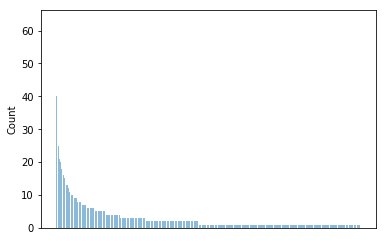

In [17]:
#iterate through all the directors of all movies and create a 2D np array which bags them into 3 groups
firstRow = np.zeros((1,2))
for i in range(wr['director'].size):
	newRow = np.zeros((1,2))
	for c in wr['director'][i]:
		if dirCounts[c] >= 8:
		    newRow[0][0] += 1
		else:
		    newRow[0][1] += 1
	firstRow = np.concatenate((firstRow, newRow), axis=0)

baggedDirectors = np.delete(firstRow, (0), axis=0)
baggedDirectors

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

## Bagging Country of Origin Feature

In [18]:
# process the country_of_origin column
countryCounts = {}
countries = np.array(wr['country_of_origin'])

def countEachCountry(item, counts):
    counts[item] = counts.get(item, 0) + 1

countColCountry = np.vectorize(countEachCountry)     
countColCountry(countries, countryCounts) #outputs count results to countryCounts dictionary
#let's get a feel for how many movies belong in the same countries.
printSortedDict(countryCounts)

Q30: 8830
Q145: 1481
Q142: 1237
Q16: 397
Q183: 358
Q17: 239
Q408: 188
Q38: 188
Q668: 182
Q29: 127
Q148: 108
Q8646: 99
Q34: 98
Q884: 85
Q35: 59
Q801: 49
Q258: 38
Q159: 38
Q40: 38
Q96: 37
Q414: 36
Q27: 34
Q31: 34
Q36: 31
Q155: 31
Q20: 27
Q15180: 24
Q55: 24
Q794: 23
Q664: 23
Q28: 18
Q869: 18
Q865: 17
Q218: 16
Q213: 16
Q33: 16
Q41: 15
Q43: 12
Q298: 12
Q928: 9
Q189: 8
Q39: 7
Q33946: 6
Q45: 6
Q225: 6
Q419: 5
Q403: 5
Q241: 4
Q36704: 4
Q79: 4
Q407199: 4
Q739: 4
Q221: 3
Q717: 3
Q77: 3
Q838261: 2
Q219: 2
Q1028: 2
Q851: 2
Q232: 2
Q889: 2
Q191: 2
Q399: 1
Q917: 1
Q224: 1
Q214: 1
Q822: 1
Q736: 1
Q792: 1
Q843: 1
Q230: 1
Q766: 1
Q334: 1
Q1041: 1
Q846: 1
Q810: 1
Q800: 1
Q786: 1
Q32: 1
Q733: 1
Q813: 1
Q252: 1
Q184: 1
Q37: 1
Q833: 1
Q974: 1
Q83286: 1
Q23792: 1
Q912: 1


In [19]:
#iterate through all rows of column countries and create a 2D np array which bags them into 4 groups
firstRow = np.zeros((1,2))
for c in countries:
    newRow = np.zeros((1,2))
    if countryCounts[c] >= 8000:
        newRow[0][0] += 1
    else:
        newRow[0][1] += 1
    firstRow = np.concatenate((firstRow, newRow), axis=0)

baggedCountries = np.delete(firstRow, (0), axis=0)
baggedCountries

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Combining Bagged Features to the Main Dataframe

In [20]:
#concatenate the bagged data to our wr dataframe.
baggedCastsDf = pd.DataFrame(baggedCasts, columns=['casts_A', 'casts_B', 'casts_C'])
baggedDirectorsDf = pd.DataFrame(baggedDirectors, columns=['dirs_A', 'dirs_B'])
baggedCountriesDf = pd.DataFrame(baggedCountries, columns=['countries_A', 'countries_B'])


wr2 = pd.concat([wr, baggedCastsDf, baggedDirectorsDf, baggedCountriesDf], ignore_index=False, axis=1)
wr2 = wr2.drop(['director', 'cast_member'], axis=1)
wr2

,country_of_origin,original_language,genre,publication_date,day,audience_average,audience_ratings,critic_average,critic_percent,audience_avg_pentile,critic_avg_pentile,casts_A,casts_B,casts_C,dirs_A,dirs_B,countries_A,countries_B
0,Q30,Q1860,[Q860626],1979-01-01,2,2.9,14648.0,6.4,68.0,1,3,7.0,6.0,4.0,1.0,0.0,1.0,0.0
1,Q30,Q1860,"[Q130232, Q3072039, Q21209409]",1957-04-10,4,4.2,104335.0,9.0,100.0,5,5,9.0,3.0,2.0,1.0,0.0,1.0,0.0
2,Q30,Q1860,[Q842256],1959-01-01,5,3.7,1062.0,7.6,83.0,4,5,5.0,2.0,2.0,1.0,0.0,1.0,0.0
3,Q30,Q1860,"[Q471839, Q1615638, Q52162262]",1954-12-23,5,3.2,68837.0,7.7,89.0,2,5,11.0,1.0,4.0,1.0,0.0,1.0,0.0
4,Q30,Q1860,"[Q471839, Q319221, Q2484376, Q130232, Q5216226...",1968-04-02,3,3.8,297648.0,9.2,92.0,5,5,3.0,3.0,13.0,1.0,0.0,1.0,0.0
5,Q258,Q1860,"[Q157394, Q319221, Q471839, Q188473]",2008-02-22,6,2.9,411268.0,3.2,8.0,1,1,3.0,0.0,8.0,1.0,0.0,0.0,1.0
6,Q30,Q1860,[Q130232],1997-01-01,4,3.6,13315.0,4.7,33.0,4,2,7.0,2.0,3.0,0.0,1.0,1.0,0.0
7,Q145,Q1860,"[Q2297927, Q1200678, Q52162262]",1935-01-01,3,3.9,23739.0,8.9,96.0,5,5,3.0,2.0,4.0,1.0,0.0,0.0,1.0
8,Q30,Q1860,[Q172980],1957-01-01,3,3.7,9206.0,7.6,96.0,4,5,5.0,3.0,2.0,1.0,0.0,1.0,0.0
9,Q142,Q150,"[Q222639, Q319221]",2003-01-01,4,2.9,2323.0,5.0,14.0,1,2,6.0,8.0,5.0,0.0,1.0,0.0,1.0


# PREDICTIONS

## Baseline Prediction Score

This is the prediction score of models using a completely random feature (so the model is basically guessing). This is the baseline score that we are trying to outperform. The code is commented out to save time of computing; further down the page, the presentation of results is set up to use pre-computed validation scores. Uncomment if the baseline needs to be recomputed.

In [21]:
# # Prepare feature with random values.
# import random
# randArray = []
# for i in range(wr2['critic_average'].count()):
#     randArray.append([random.random()])
# randnpArray = np.array(randArray)
# X = randnpArray.reshape(-1, 1)
# y = (wr2['critic_avg_pentile'].values).astype('int').astype('str')

# # critic score Bayesian model
# n = 100
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     bayes_model = GaussianNB()
#     bayes_model.fit(X_train, y_train)
#     totalTrain += bayes_model.score(X_train, y_train)
#     totalValid += bayes_model.score(X_valid, y_valid)
#     array.append(bayes_model.score(X_valid, y_valid))

# base_critic_bayesTrainScore = totalTrain/n
# base_critic_bayesValidScore = totalValid/n
# print("training: " + str(base_critic_bayesTrainScore))
# print("validation: " + str(base_critic_bayesValidScore))

# # critic score k-nearest neighbours (scaled)
# n_nbs = 15
# n = 10
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     knn_model = make_pipeline(
#         MinMaxScaler(),
#         KNeighborsClassifier(n_neighbors=n_nbs)
#         )
#     knn_model.fit(X_train, y_train)
#     totalTrain += knn_model.score(X_train, y_train)
#     totalValid += knn_model.score(X_valid, y_valid)
#     array.append(knn_model.score(X_valid, y_valid))

# base_critic_knnTrainScore = totalTrain/n
# base_critic_knnValidScore = totalValid/n    
# print("training: " + str(base_critic_knnTrainScore))
# print("validation: " + str(base_critic_knnValidScore))

# # critic score Support Vector machine
# n = 2
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     svc_model = SVC(kernel='rbf', C=5, gamma='scale', decision_function_shape='ovr')
#     svc_model.fit(X_train, y_train)
#     totalTrain += svc_model.score(X_train, y_train)
#     totalValid += svc_model.score(X_valid, y_valid)    
#     array.append(svc_model.score(X_valid, y_valid))

# base_critic_svmTrainScore = totalTrain/n
# base_critic_svmValidScore = totalValid/n    
# print("training: " + str(base_critic_svmTrainScore))
# print("validation: " + str(base_critic_svmValidScore))

# # critic score neural network
# model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
# model.fit(X_train, y_train)

# n = 8
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     neural_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,4), activation='logistic')
#     neural_model.fit(X_train, y_train)
#     totalTrain += neural_model.score(X_train, y_train)
#     totalValid += neural_model.score(X_valid, y_valid)    
#     array.append(svc_model.score(X_valid, y_valid))

# base_critic_neuralTrainScore = totalTrain/n
# base_critic_neuralValidScore = totalValid/n    
# print("training: " + str(base_critic_neuralTrainScore))
# print("validation: " + str(base_critic_neuralValidScore))

In [22]:
# # Get the baselines for the audience score 
# y = (wr2['audience_avg_pentile'].values).astype('int').astype('str')

# # audience score Bayesian model
# n = 100
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     bayes_model = GaussianNB()
#     bayes_model.fit(X_train, y_train)
#     totalTrain += bayes_model.score(X_train, y_train)
#     totalValid += bayes_model.score(X_valid, y_valid)
#     array.append(bayes_model.score(X_valid, y_valid))

# base_aud_bayesTrainScore = totalTrain/n
# base_aud_bayesValidScore = totalValid/n
# print("training: " + str(base_aud_bayesTrainScore))
# print("validation: " + str(base_aud_bayesValidScore))

# # audience score k-nearest neighbours (scaled)
# n_nbs = 15
# n = 10
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     knn_model = make_pipeline(
#         MinMaxScaler(),
#         KNeighborsClassifier(n_neighbors=n_nbs)
#         )
#     knn_model.fit(X_train, y_train)
#     totalTrain += knn_model.score(X_train, y_train)
#     totalValid += knn_model.score(X_valid, y_valid)
#     array.append(knn_model.score(X_valid, y_valid))

# base_aud_knnTrainScore = totalTrain/n
# base_aud_knnValidScore = totalValid/n    
# print("training: " + str(base_aud_knnTrainScore))
# print("validation: " + str(base_aud_knnValidScore))

# # audience score Support Vector machine
# n = 2
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     svc_model = SVC(kernel='rbf', C=5, gamma='scale', decision_function_shape='ovr')
#     svc_model.fit(X_train, y_train)
#     totalTrain += svc_model.score(X_train, y_train)
#     totalValid += svc_model.score(X_valid, y_valid)    
#     array.append(svc_model.score(X_valid, y_valid))

# base_aud_svmTrainScore = totalTrain/n
# base_aud_svmValidScore = totalValid/n    
# print("training: " + str(base_aud_svmTrainScore))
# print("validation: " + str(base_aud_svmValidScore))

# # audience score neural network
# model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
# model.fit(X_train, y_train)

# n = 8
# totalTrain = 0
# totalValid = 0
# array = []
# for i in range(n):
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y)
#     neural_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,4), activation='logistic')
#     neural_model.fit(X_train, y_train)
#     totalTrain += neural_model.score(X_train, y_train)
#     totalValid += neural_model.score(X_valid, y_valid)    
#     array.append(svc_model.score(X_valid, y_valid))

# base_aud_neuralTrainScore = totalTrain/n
# base_aud_neuralValidScore = totalValid/n    
# print("training: " + str(base_aud_neuralTrainScore))
# print("validation: " + str(base_aud_neuralValidScore))

## Predicting Critic Average

In [23]:
# Prepare values. Play around with these categories to find the best fit
trainedFeatures = ['casts_A', 'casts_B', 'casts_C', 'countries_A', 'countries_B']
X = wr2[trainedFeatures].values
print(X)
y = (wr2['critic_avg_pentile'].values).astype('int').astype('str')

[[7. 6. 4. 1. 0.]
 [9. 3. 2. 1. 0.]
 [5. 2. 2. 1. 0.]
 ...
 [4. 2. 2. 0. 1.]
 [6. 2. 3. 0. 1.]
 [8. 5. 1. 0. 1.]]


In [24]:
# Bayesian model
n = 20
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    bayes_model = GaussianNB()
    bayes_model.fit(X_train, y_train)
    totalTrain += bayes_model.score(X_train, y_train)
    totalValid += bayes_model.score(X_valid, y_valid)
    array.append(bayes_model.score(X_valid, y_valid))

critic_bayesTrainScore = totalTrain/n
critic_bayesValidScore = totalValid/n
print("training: " + str(critic_bayesTrainScore))
print("validation: " + str(critic_bayesValidScore))

training: 0.2726890367905343
validation: 0.2700083194675541


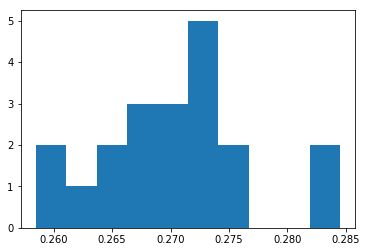

In [25]:
#lets see what the distribution of the scores look like
plt.hist(array)
plt.show()

In [26]:
# k-nearest neighbours (scaled)
n_nbs = 15
n = 20
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    knn_model = make_pipeline(
        MinMaxScaler(),
        KNeighborsClassifier(n_neighbors=n_nbs)
        )
    knn_model.fit(X_train, y_train)
    totalTrain += knn_model.score(X_train, y_train)
    totalValid += knn_model.score(X_valid, y_valid)
    array.append(knn_model.score(X_valid, y_valid))

critic_knnTrainScore = totalTrain/n
critic_knnValidScore = totalValid/n    
print("training: " + str(critic_knnTrainScore))
print("validation: " + str(critic_knnValidScore))

training: 0.3470558328711407
validation: 0.24506378258458122


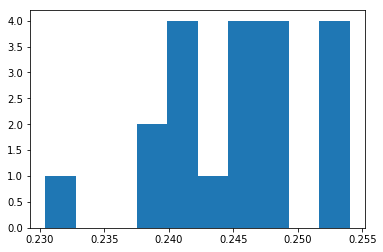

In [27]:
#lets see what the distribution of the scores look like
plt.hist(array)
plt.show()

In [28]:
# Support Vector machine

n = 2
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    svc_model = SVC(kernel='rbf', C=5, gamma='scale', decision_function_shape='ovr')
    svc_model.fit(X_train, y_train)
    totalTrain += svc_model.score(X_train, y_train)
    totalValid += svc_model.score(X_valid, y_valid)    
    array.append(svc_model.score(X_valid, y_valid))

critic_svmTrainScore = totalTrain/n
critic_svmValidScore = totalValid/n    
print("training: " + str(critic_svmTrainScore))
print("validation: " + str(critic_svmValidScore))

training: 0.29256794231835825
validation: 0.27551303383250136


In [29]:
model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
model.fit(X_train, y_train)

n = 8
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    neural_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,4), activation='logistic')
    neural_model.fit(X_train, y_train)
    totalTrain += neural_model.score(X_train, y_train)
    totalValid += neural_model.score(X_valid, y_valid)    
    array.append(svc_model.score(X_valid, y_valid))

critic_neuralTrainScore = totalTrain/n
critic_neuralValidScore = totalValid/n    
print("training: " + str(critic_neuralTrainScore))
print("validation: " + str(critic_neuralValidScore))

training: 0.2830121094472176
validation: 0.2785981697171381


## Predicting Audience Average

In [30]:
y = wr2['audience_avg_pentile'].values.astype('int').astype('str')

In [31]:
# Bayesian model
n = 100
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    bayes_model = GaussianNB()
    bayes_model.fit(X_train, y_train)
    totalTrain += bayes_model.score(X_train, y_train)
    totalValid += bayes_model.score(X_valid, y_valid)
    array.append(bayes_model.score(X_valid, y_valid))

aud_bayesTrainScore = totalTrain/n
aud_bayesValidScore = totalValid/n
print("training: " + str(aud_bayesTrainScore))
print("validation: " + str(aud_bayesValidScore))

training: 0.2808763172490294
validation: 0.27922628951747086


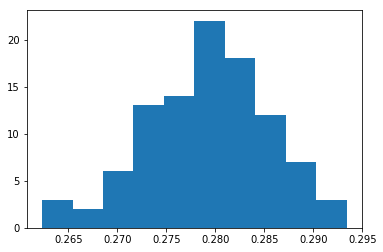

In [32]:
#lets see what the distribution of the scores look like
plt.hist(array)
plt.show()

In [33]:
# k-nearest neighbours (scaled)
n_nbs = 15
n = 20
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    knn_model = make_pipeline(
        MinMaxScaler(),
        KNeighborsClassifier(n_neighbors=n_nbs)
        )
    knn_model.fit(X_train, y_train)
    totalTrain += knn_model.score(X_train, y_train)
    totalValid += knn_model.score(X_valid, y_valid)
    array.append(knn_model.score(X_valid, y_valid))

aud_knnTrainScore = totalTrain/n
aud_knnValidScore = totalValid/n    
print("training: " + str(aud_knnTrainScore))
print("validation: " + str(aud_knnValidScore))

training: 0.3562118691070438
validation: 0.2557127010537993


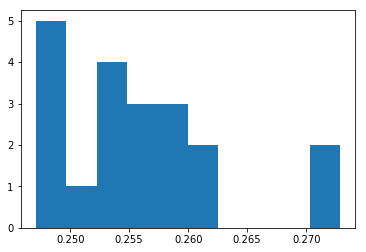

In [34]:
#lets see what the distribution of the scores look like
plt.hist(array)
plt.show()

In [35]:
# Support Vector machine

n = 2
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    svc_model = SVC(kernel='rbf', C=5, gamma='scale', decision_function_shape='ovr')
    svc_model.fit(X_train, y_train)
    totalTrain += svc_model.score(X_train, y_train)
    totalValid += svc_model.score(X_valid, y_valid)    
    array.append(svc_model.score(X_valid, y_valid))

aud_svmTrainScore = totalTrain/n
aud_svmValidScore = totalValid/n    
print("training: " + str(aud_svmTrainScore))
print("validation: " + str(aud_svmValidScore))

training: 0.30458495100758
validation: 0.29076539101497506


In [36]:
model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
model.fit(X_train, y_train)

n = 8
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    neural_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(4,4), activation='logistic')
    neural_model.fit(X_train, y_train)
    totalTrain += neural_model.score(X_train, y_train)
    totalValid += neural_model.score(X_valid, y_valid)    
    array.append(svc_model.score(X_valid, y_valid))

aud_neuralTrainScore = totalTrain/n
aud_neuralValidScore = totalValid/n    
print("training: " + str(aud_neuralTrainScore))
print("validation: " + str(aud_neuralValidScore))

training: 0.298680440007395
validation: 0.2978022739877981


## Summary of Results:

In [37]:
# Use this code if recomputing the baseline values

# print("Features used to train model:\n" + str(trainedFeatures) + "\n")
# print('CriticAvg========================')
# print ("Bayes: Baseline %.3f" % base_critic_bayesTrainScore + " %.3f" % base_critic_bayesValidScore
#       + " || Model %.3f" % critic_bayesTrainScore + " %.3f" % critic_bayesValidScore)
# print ("knn: Baseline %.3f" % base_critic_knnTrainScore + " %.3f" % base_critic_knnValidScore
#       + " || Model %.3f" % critic_knnTrainScore + " %.3f" % critic_knnValidScore)
# print ("SVM: Baseline %.3f" % base_critic_svmTrainScore + " %.3f" % base_critic_svmValidScore
#       + " || Model %.3f" % critic_svmTrainScore + " %.3f" % critic_svmValidScore)
# print ("neural: Baseline %.3f" % base_critic_neuralTrainScore + " %.3f" % base_critic_neuralValidScore
#       + " || Model %.3f" % critic_neuralTrainScore + " %.3f" % critic_neuralValidScore)
# print('AudienceAvg========================')
# print ("Bayes: Baseline %.3f" % base_aud_bayesTrainScore + " %.3f" % base_aud_bayesValidScore
#       + " || Model %.3f" % aud_bayesTrainScore + " %.3f" % aud_bayesValidScore)
# print ("knn: Baseline %.3f" % base_aud_knnTrainScore + " %.3f" % base_aud_knnValidScore
#       + " || Model %.3f" % aud_knnTrainScore + " %.3f" % aud_knnValidScore)
# print ("SVM: Baseline %.3f" % base_aud_svmTrainScore + " %.3f" % base_aud_svmValidScore
#       + " || Model %.3f" % aud_svmTrainScore + " %.3f" % aud_svmValidScore)
# print ("neural: Baseline %.3f" % base_aud_neuralTrainScore + " %.3f" % base_aud_neuralValidScore
#       + " || Model %.3f" % aud_neuralTrainScore + " %.3f" % aud_neuralValidScore)

In [38]:
#Otherwise, use pre-computed baseline values.

print("Features used to train model:\n" + str(trainedFeatures) + "\n")
print('CriticAvg========================')
print ("Bayes: Baseline 0.226"
      + " || Model %.3f" % critic_bayesTrainScore + " %.3f" % critic_bayesValidScore)
print ("knn: Baseline 0.203"
      + " || Model %.3f" % critic_knnTrainScore + " %.3f" % critic_knnValidScore)
print ("SVM: Baseline 0.224"
      + " || Model %.3f" % critic_svmTrainScore + " %.3f" % critic_svmValidScore)
print ("neural: Baseline 0.225"
      + " || Model %.3f" % critic_neuralTrainScore + " %.3f" % critic_neuralValidScore)
print('AudienceAvg========================')
print ("Bayes: Baseline 0.233"
      + " || Model %.3f" % aud_bayesTrainScore + " %.3f" % aud_bayesValidScore)
print ("knn: Baseline 0.211"
      + " || Model %.3f" % aud_knnTrainScore + " %.3f" % aud_knnValidScore)
print ("SVM: Baseline 0.237"
      + " || Model %.3f" % aud_svmTrainScore + " %.3f" % aud_svmValidScore)
print ("neural: Baseline 0.236"
      + " || Model %.3f" % aud_neuralTrainScore + " %.3f" % aud_neuralValidScore)

Features used to train model:
['casts_A', 'casts_B', 'casts_C', 'countries_A', 'countries_B']

CriticAvg========================
Bayes: Baseline 0.226 || Model 0.273 0.270
knn: Baseline 0.203 || Model 0.347 0.245
SVM: Baseline 0.224 || Model 0.293 0.276
neural: Baseline 0.225 || Model 0.283 0.279
AudienceAvg========================
Bayes: Baseline 0.233 || Model 0.281 0.279
knn: Baseline 0.211 || Model 0.356 0.256
SVM: Baseline 0.237 || Model 0.305 0.291
neural: Baseline 0.236 || Model 0.299 0.298
